In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import matplotlib.ticker as mtick
conn = sqlite3.connect('test_database')
c = conn.cursor()

In [3]:
query = """
SELECT *
FROM reliability_table
WHERE Vendor_Number = 566041
"""
df = pd.read_sql_query(query,conn)
df

,Supplier,Vendor_Number,Purchasing_Organization,PO_Document_Date,PO_Number,PO_Line_Number,Material,Material_Group,MRP_controller,Changed_On_Date,Confirmed_Delivery_Date,Creation_Date_of_Confirmation,Posting_Date,Item_Delivery_Date,Scheduled_relevant_delivery_date,Error_Code
0,INTEX TECHNOLOGIES LLC,566041,1000,2019-03-20,4508930359,1,1072524001,017,JNK,2021-03-06 00:00:00,2019-04-08 00:00:00,None,2019-04-04 00:00:00,0.0,2019-04-08 00:00:00,None
1,INTEX TECHNOLOGIES LLC,566041,1000,2020-10-21,4509922768,1,1038034001-6205,017,212,2020-11-05 00:00:00,None,None,2020-11-06 00:00:00,0.0,2020-11-04 00:00:00,W
2,INTEX TECHNOLOGIES LLC,566041,1000,2021-09-07,4510356126,1,1038034001-6059,017,212,2021-09-07 00:00:00,None,None,2021-09-17 00:00:00,0.0,2021-09-20 00:00:00,None
3,INTEX TECHNOLOGIES LLC,566041,1000,2019-08-19,4509242074,1,1072524001,017,JNK,2021-08-07 00:00:00,2019-09-03 00:00:00,None,2019-09-04 00:00:00,0.0,2019-09-03 00:00:00,C
4,INTEX TECHNOLOGIES LLC,566041,1000,2022-05-26,4510744115,2,1352155002,017,MIN,2022-06-01 00:00:00,None,None,2022-06-10 00:00:00,0.0,2022-06-10 00:00:00,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,INTEX TECHNOLOGIES LLC,566041,1000,2019-05-10,4509036015,2,1072524002,017,JNK,2021-05-08 00:00:00,2019-05-23 00:00:00,None,2019-05-23 00:00:00,0.0,2019-05-24 00:00:00,None
406,INTEX TECHNOLOGIES LLC,566041,1000,2019-07-09,4509158417,1,1072524001,017,JNK,2021-07-10 00:00:00,2019-07-23 00:00:00,None,2019-07-24 00:00:00,0.0,2019-07-23 00:00:00,F
407,INTEX TECHNOLOGIES LLC,566041,1000,2021-02-03,4510049859,2,1038034002-6059,017,212,2021-02-03 00:00:00,None,None,2021-02-17 00:00:00,0.0,2021-02-17 00:00:00,None
408,INTEX TECHNOLOGIES LLC,566041,1000,2019-07-18,4509177441,1,1072524001,017,JNK,2021-07-10 00:00:00,2019-08-01 00:00:00,None,2019-08-05 00:00:00,0.0,2019-08-01 00:00:00,C


In [2]:
query = """
SELECT *
FROM
    (SELECT
        strftime('%Y-%m-01',PO_Document_Date) as Month,
        CASE
            WHEN Error_Code is null then 'No error'
            Else 'Error'
        END AS error,
        count(*) as orders
    FROM reliability_table
    GROUP BY strftime('%Y-%m-01',PO_Document_Date), (CASE
            WHEN Error_Code is null then 'No error'
            Else 'Error'
        END)) as t1
LEFT JOIN
    (SELECT
        strftime('%Y-%m-01',PO_Document_Date) as Month2,
        count(*) as total_orders
    FROM reliability_table
    GROUP BY strftime('%Y-%m-01',PO_Document_Date)) as t2
on t1.Month = t2.Month2
"""
df = pd.read_sql_query(query,conn)
df['Month'] = pd.to_datetime(df["Month"])
df['per'] = df.orders/ df.total_orders * 100

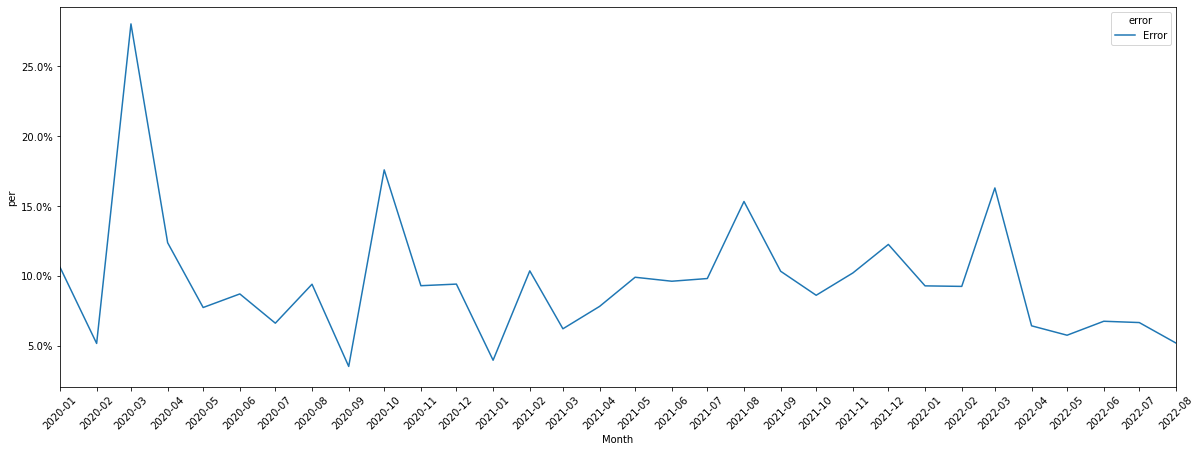

In [3]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y-%m') #This is a format. Will be clear in Screenshot

fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(data=df[df['error']=='Error'], x="Month", y="per", hue='error')

axes.xaxis.set_major_locator(months)
axes.xaxis.set_major_formatter(years_fmt)
axes.xaxis.set_minor_locator(months)

plt.xticks(rotation = 45)

axes.set_xlim([datetime.date(2020, 1, 1), datetime.date(2022, 8, 1)])
axes.yaxis.set_major_formatter(mtick.PercentFormatter())

In [59]:
query = """
SELECT Month, material, avg(order_price) as Avg_Cost
FROM (
SELECT t1.Vendor_Number, t1.Purchasing_Organization, t1.PO_Document_Date, strftime('%Y-%m-01',t1.PO_Document_Date) as Month, t1.PO_Number, t1.PO_Line_Number, t1.material,
    t2.Vendor_Number as v2, t2.material as mat2, t2.order_price
FROM reliability_table as t1
INNER JOIN schedule_table as t2 on (t1.Vendor_Number = t2.Vendor_Number) and (t1.Material = t2.Material)
WHERE t2.material in (select part_number from components_table)
GROUP BY t1.Vendor_Number, t1.Purchasing_Organization, t1.PO_Document_Date, t1.PO_Number, t1.PO_Line_Number, t1.material,
    t2.Vendor_Number, t2.material, t2.order_price, strftime('%Y-%m-01',t1.PO_Document_Date)) as tab1
GROUP BY month, material
ORDER BY avg(order_price) desc
"""
df = pd.read_sql_query(query,conn)
df['Month'] = pd.to_datetime(df["Month"])
df

,Month,material,Avg_Cost
0,2022-02-01,1002004805,49324.80
1,2022-03-01,1002004805,49324.80
2,2019-04-01,1002004805,49324.80
3,2019-06-01,1002004805,49324.80
4,2019-10-01,1002004805,49324.80
...,...,...,...
4744,2022-05-01,858000505,8.18
4745,2022-06-01,858000505,8.18
4746,2019-02-01,1025346001-9160,0.11
4747,2019-03-01,1025346001-9160,0.11


(18262.0, 19205.0)

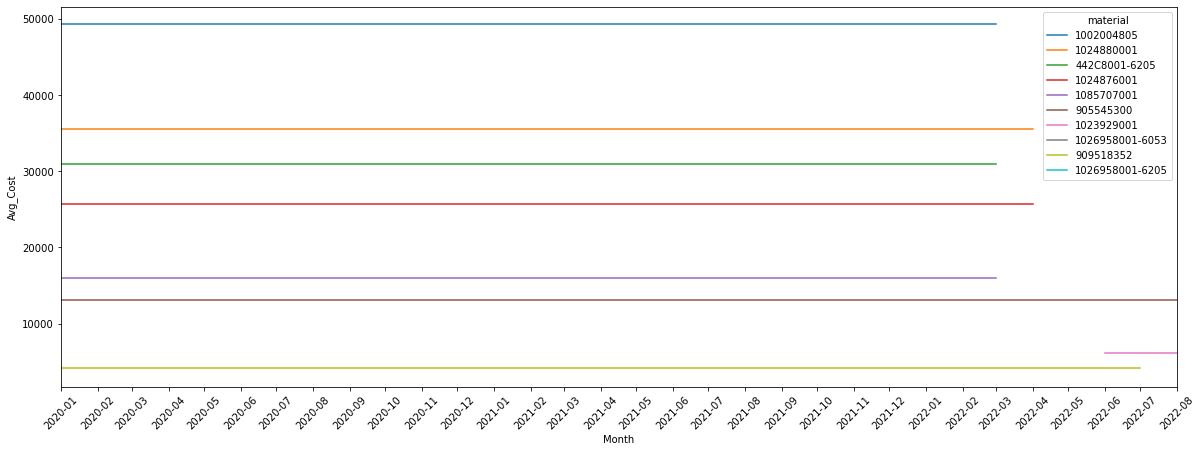

In [61]:
fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(data=df.loc[0:159], x="Month", y="Avg_Cost", hue='material')

axes.xaxis.set_major_locator(months)
axes.xaxis.set_major_formatter(years_fmt)
axes.xaxis.set_minor_locator(months)

plt.xticks(rotation = 45)

axes.set_xlim([datetime.date(2020, 1, 1), datetime.date(2022, 8, 1)])